## Projeto: Transformada de Hilbert-Huang

---

#### Por [Beatriz Coimbra](https://github.com/beatrizmcoimbra) e [Fernanda Scovino](https://github.com/fernandascovino)

#### Resumo

Implementação da transformada de Hilbert-Huang para identificação de sons e expansão do [verbete na *Wikipédia*](https://pt.wikipedia.org/wiki/Transformada_de_Hilbert-Huang).

A transformada de Hilbert-Huang é uma técnica de decomposição de sinais em tempo-frequência em duas fases (EMD - Método de decomposição do modo empírico, e HSA - Análise espectral de Hilbert). Esta técnica foi desenvolvida num dos organismos da NASA por Northen E. Huang em 1998, e tem sido aplicada a sinais nos mais variados ramos da ciência, que vão desde a engenharia à medicina.<sup>1</sup>

O método de decomposição do modo empírico (EMD) nos permite decompor um conjunto de dados em um número
finito de componentes mais simples, chamados de funções do modo intrínseco (IMF).<sup>2</sup> Uma função de modo intrínseco é definida como qualquer função que tenha o mesmo, ou diferindo no máximo por um, números de zeros (cruzam o eixo x) e extremos, e também ter "envelopes simétricos" definidos pelos máximos e mínimos locais, respectivamente (os dados devem se localizar entre essas funções).<sup>3</sup>. As splines cúbicas são utilizadas para traçarmos esses envelopes, conectando os máximos/mínimos locais.<sup>4</sup>

#### Referências

1: [Hilbert-Huang transform - Wikipédia](https://en.wikipedia.org/wiki/Hilbert%E2%80%93Huang_transform)

2: [Tese *Utilização do método de decomposição empírico no processamento de dados de mobilidade urbana*, de Juliana Crespo (EMAp)](https://emap.fgv.br/dissertacao/utilizacao-metodo-de-decomposicao-empirico-processamento-de-dados-de-mobilidade-urbana)

3: [Hilbert-Huang transform - Scholarpedia](http://www.scholarpedia.org/article/Hilbert-Huang_transform)

4: [Spline - Wikipédia](https://pt.wikipedia.org/wiki/Spline)

5: [Cheney, W. & Kincaid, D. *Numerical Mathematics and Computing*](https://www.amazon.com/Numerical-Mathematics-Computing-Ward-Cheney/dp/1133103715/ref=dp_ob_title_bk)

6: [PyHHT Tutorials](https://pyhht.readthedocs.io/en/latest/tutorials.html)

7: [PyHHT Documentation](https://media.readthedocs.org/pdf/pyhht/latest/pyhht.pdf)

### Criando os sons 

In [1]:
import numpy as np
import sounddevice as sd
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Vamos escolher inicialmente a duração das notas como 8000?? para podermos escutar o som. 

Posteriormente, para possibilitar os cálculos, vamos diminuir essa duração.

In [38]:
Fs = 8000
tempo = 8000

In [39]:
def cria_nota(f,Fs,tempo=Fs):
    
    """
    Cria o sinal correspondente à frequência escolhida (nota).
    
    :param f: frequência da nota
    :param Fs: frequência de amostragem
    :param tempo: duração da nota
    """
    
    x = np.arange(tempo)
    y = np.sin(2*np.pi*f*x/Fs)
    
    return y

In [40]:
freq_notas_dic = {
    'do': 261.6,
    'do#': 277,
    're': 293.5,
    're#': 311,
    'mi': 329.6,
    'fa': 349.2,
    'fa#': 370,
    'sol': 392,
    'sol#': 415.1,
    'la': 440,
    'la#': 466.2,
    'si': 493.8
}

In [41]:
def cria_musica(text, Fs, tempo):
    
    """
    Cria a música a partir de uma string de notas.
    
    :param text: string com as notas
    :param Fs: frequência de amostragem
    :param tempo: duração da nota
    """
    
    notas = text.split(',')
    musica = []
    
    for nota in notas:
        
        freq = cria_nota(freq_notas_dic[nota], Fs, tempo)
        musica = np.concatenate((musica, freq),axis=0)
            
    t = len(notas)*tempo
    return t, musica

In [42]:
t, teste = cria_musica('do,fa,mi,re,do,re,do,do,do,re,do,re,mi,fa', Fs, tempo)

In [43]:
sd.play(teste)

In [44]:
t

112000

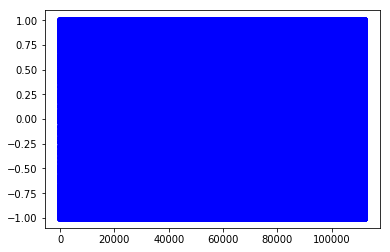

In [45]:
plt.plot(list(range(len(teste))), teste, 'bo')

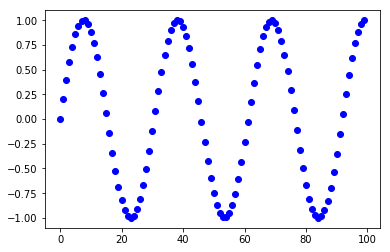

In [46]:
plt.plot(list(range(len(teste[:100]))), teste[:100], 'bo')

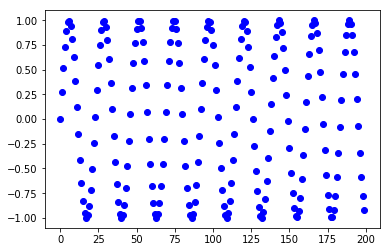

In [47]:
plt.plot(list(range(len(teste[8000:8200]))), teste[8000:8200], 'bo')

### Decompondo os sinais

In [103]:
from pyhht.visualization import plot_imfs
from pyhht.emd import EMD

In [111]:
tempo = 400
t, x = cria_musica('do,fa,mi,re,do,re,do,do,do,re,do,re,mi,fa', tempo, tempo)

In [106]:
t

5600

In [112]:
len(x)

5600

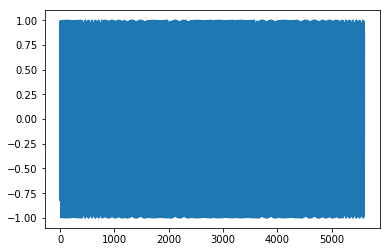

In [113]:
plt.plot(x)

#### 1. Identificando os mínimos e máximos do sinal $x(t)$

In [119]:
x[:10]

array([ 0.        , -0.8235326 ,  0.93432894, -0.236499  , -0.66601187,
        0.9921147 , -0.45957986, -0.47070393,  0.99361131, -0.65658576])

In [141]:
from scipy.signal import argrelextrema

max_t = argrelextrema(x, np.greater)[0]
min_t = argrelextrema(x, np.less)[0]

Achamos as posições da lista que correspondem aos mínimos e máximos locais:

In [142]:
max_t

array([   2,    5,    8, ..., 5576, 5584, 5592])

In [143]:
min_t

array([   1,    4,    7, ..., 5580, 5588, 5596])

Com as posições, buscamos os valores correspondentes:

In [144]:
max_x = [x[i] for i in max_t]
min_x = [x[i] for i in min_t]

In [146]:
max_x[:10]

[0.934328942456612,
 0.9921147013144778,
 0.9936113105200085,
 0.9387338576538743,
 0.8305958991958131,
 0.6753328081210304,
 0.48175367410171616,
 0.6470559615694434,
 0.8090169943749426,
 0.9250772068344575]

In [147]:
min_x[:10]

[-0.8235325976284275,
 -0.6660118674342518,
 -0.4707039321653329,
 -0.6565857557529561,
 -0.8163392507171836,
 -0.9297764858882485,
 -0.9904614256966511,
 -0.994951016981301,
 -0.9429905358928649,
 -0.8375280400421464]

#### 2. Encontrando os envelope superior e inferior de $x(t)$ passando um spline cúbico através dos máximos e mínimos respectivamente

Utilizando o método [`scipy.interpolate.UnivariateSpline`](https://docs.scipy.org/doc/scipy-0.19.1/reference/generated/scipy.interpolate.UnivariateSpline.html) para a interpolação de spline cúbica:

In [156]:
from scipy.interpolate import UnivariateSpline

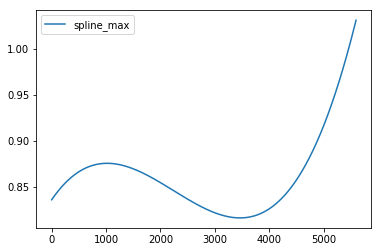

In [168]:
f_max = UnivariateSpline(max_t, max_x, k=3)
s_max = f_max(max_t)

plt.plot(max_t, s_max, label='spline_max')
plt.legend()

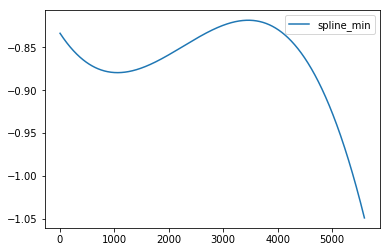

In [169]:
f_min = UnivariateSpline(min_t, min_x, k=3)
s_min = f_min(min_t)

plt.plot(min_t, s_min, label='spline_min')
plt.legend()

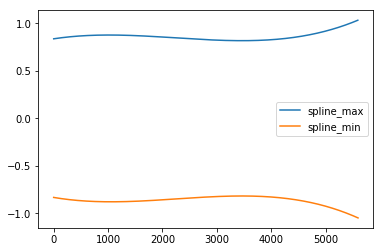

In [170]:
plt.plot(max_t, s_max, label='spline_max')
plt.plot(min_t, s_min, label='spline_min')
plt.legend()

#### 3. Calcule a média dos envelopes superior e inferior como $m(t)$

In [172]:
t = list(range(len(x)))
m_t = (f_max(t) + f_min(t))/2

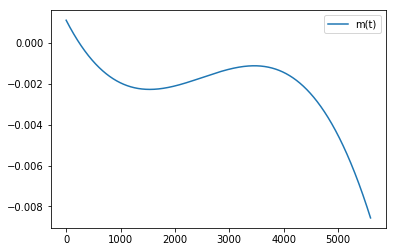

In [173]:
plt.plot(m_t, label='m(t)')
plt.legend()

#### 4. Obter um candidato do FMI usando a fórmula $h_{k}(t) = x(t) - m(t)$

In [174]:
h_t = x - m_t

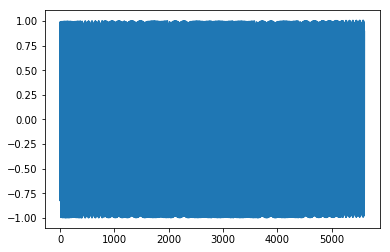

In [176]:
plt.plot(h_t)

#### 4. Verifique se as propriedades $h_{k}(t)$ é uma função do modo intrínseco (IMF), ou seja:

1. Em todo o conjunto de dados, o número de extremos e números
de raízes (zeros da função) devem ser iguais ou diferem por 1.
2. Em qualquer ponto, o valor médio do envelope definido pelo máximo local e o envelope definido pelo mínimo local é zero.

In [188]:
sum(h_t == 0)

0

----

### Utopia

In [80]:
decomposer = EMD(teste)
imfs = decomposer.decompose()

Mode 3, Iteration 600
0 minima > 0; 204 maxima < 0.
Mode 5, Iteration 800
0 minima > 0; 99 maxima < 0.
Mode 7, Iteration 1000
1 minima > 0; 31 maxima < 0.
Mode 7, Iteration 1200
0 minima > 0; 33 maxima < 0.
Mode 7, Iteration 1400
0 minima > 0; 32 maxima < 0.


2
3
4
5
6
7
8
9
10
11


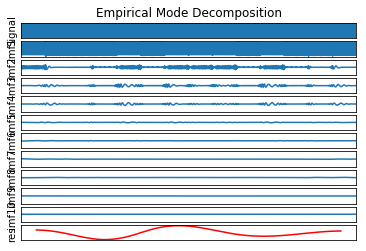

In [81]:
plot_imfs(teste, imfs)

### Rascunho

In [95]:
t = np.linspace(0, 1, 1000)
modes = np.sin(2 * pi * f * t /8000) + np.sin(2 * pi * 440 * t /8000)

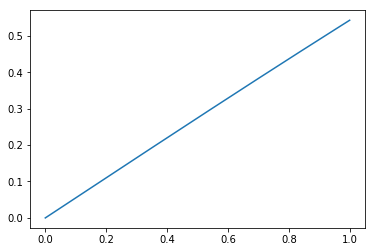

In [99]:
plt.plot(t, modes)

In [97]:
sd.play(modes)

In [84]:
tempo = 100
Fs = 100
f = 261.6

x = np.arange(tempo)
y = np.sin(2 * np.pi * f * x/Fs)

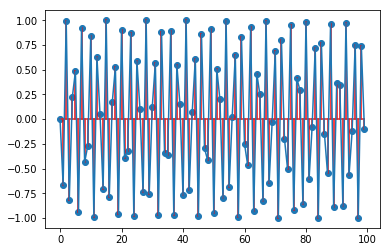

In [101]:
plt.stem(x, y, 'r', )
plt.plot(x, y)